Блок 0.5.

Загрузка библиотек

In [ ]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import seaborn as sns


# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

Блок 0.5.

0.5.1 Загрузка тернировочного сета

In [87]:
# считываем тренировачный сет
df = pd.read_csv('data/train_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [ ]:
# знакомимся со структурой сета
df.head()

0.5.2 Работаем с пропусками

car_vin                   67.177143
vehicle_interior_color    19.194286
doors_cnt                  2.128571
vehicle_color              1.145714
vehicle_model              0.020000
vehicle_manufacturer       0.002857
vehicle_category           0.002857
vehicle_gearbox_type       0.002857
wheels                     0.002857
dtype: float64

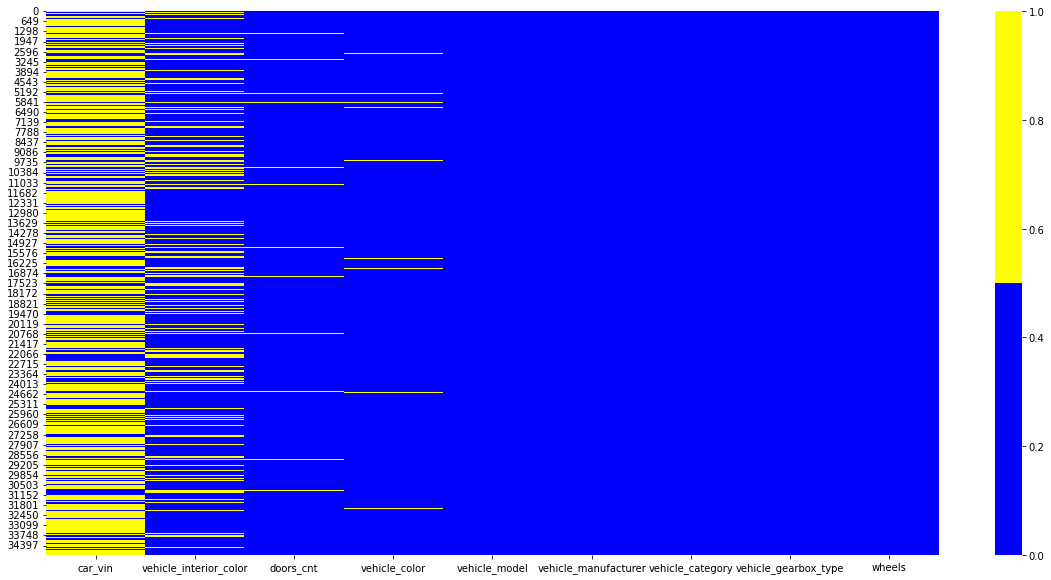

In [88]:
#Выявление процента пропусков по столбцам
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

#через тепловую карту
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(20, 10))
cols = cols_with_null.index
ax = sns.heatmap(
    df[cols].isnull(),
    cmap=sns.color_palette(colors),
)


Тепловая карта показала, что в четырех признаках имеются пропуски: car_vin, vehicle_interior_color, doors_cnt, vehicle_color.

In [89]:
# vin содержит в себе закодированные сведения об автомобиле, для расшифровки его необходимо специально создавать алгоритм,
# пробуем удалить этот признак, т.к. в нём имеется много пропусков, также из-за уникальности значений признак неинформативен.
df.drop('car_vin', axis=1, inplace=True)

In [78]:
# проверка: признаки car_vin
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_leather_interior    35000 non-null  int64  
 12  deal_type               35000 non-null  object 
 13  final_price             35000 non-null  float64
dtypes: float64(1), int64(4), object(9)
mem

Признак doors_cnt представлен в виде дроби и имеет тип object. Т.к. не могу прогнозировать как признак будет преобразован, то отдадим модели уже преобразованный признак.
В признаке указано количество дверей для пассажиров / количество дверей для пассажиров+дверь(крышка)багажника. У водителей можно встретить выражение: "Пятидверный седан", будем отталкиваться от этого и оставим кколичество дверей для пассажиров+дверь(крышка)багажника

In [90]:
# оставляем последний символ строки
df['doors_cnt'] = df['doors_cnt'] = df.doors_cnt.str[-1]
df.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,5,Right-hand drive,Silver,Black,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,5,Left wheel,Silver,Black,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,3,Left wheel,Silver,Black,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,5,Left wheel,Blue,Black,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,5,Left wheel,Black,NaN,1,For Sale,5000.0


In [91]:
#пропуски в признаке doors_cnt заполним модой
mode_doors = df['doors_cnt'].mode() # mode = 5
df['doors_cnt'].fillna('mode_doors', inplace=True)
#df.info()

Также заполним модой нулевые значения в остальных признаках

In [92]:
#пропуски в признаке vehicle_color заполним модой
mode_color = df['vehicle_color'].mode() # mode = Black
df['vehicle_color'].fillna('mode_color', inplace=True)

#пропуски в признаке vehicle_interior_color заполним модой
mode_int_color = df['vehicle_interior_color'].mode() # mode = Black
df['vehicle_interior_color'].fillna('mode_int_color', inplace=True)

#пропуски в признаке vehicle_model заполним модой
mode_model = df['vehicle_model'].mode() # mode = Black
df['vehicle_model'].fillna('mode_model', inplace=True)

#пропуски в признаке vehicle_manufacturer заполним модой
mode_manufacture = df['vehicle_manufacturer'].mode() # mode = Black
df['vehicle_manufacturer'].fillna('mode_manufacture', inplace=True)

#пропуски в признаке vehicle_category заполним модой
mode_category = df['vehicle_category'].mode() # mode = Black
df['vehicle_category'].fillna('mode_category', inplace=True)

#пропуски в признаке vehicle_gearbox_type заполним модой
mode_gear = df['vehicle_gearbox_type'].mode() # mode = Black
df['vehicle_gearbox_type'].fillna('mode_gear', inplace=True)

#пропуски в признаке wheels заполним модой
mode_weels = df['wheels'].mode() # mode = Black
df['wheels'].fillna('mode_weels', inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  35000 non-null  object 
 9   vehicle_color           35000 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_leather_interior    35000 non-null  int64  
 12  deal_type               35000 non-null  object 
 13  final_price             35000 non-null  float64
dtypes: float64(1), int64(4), object(9)
mem

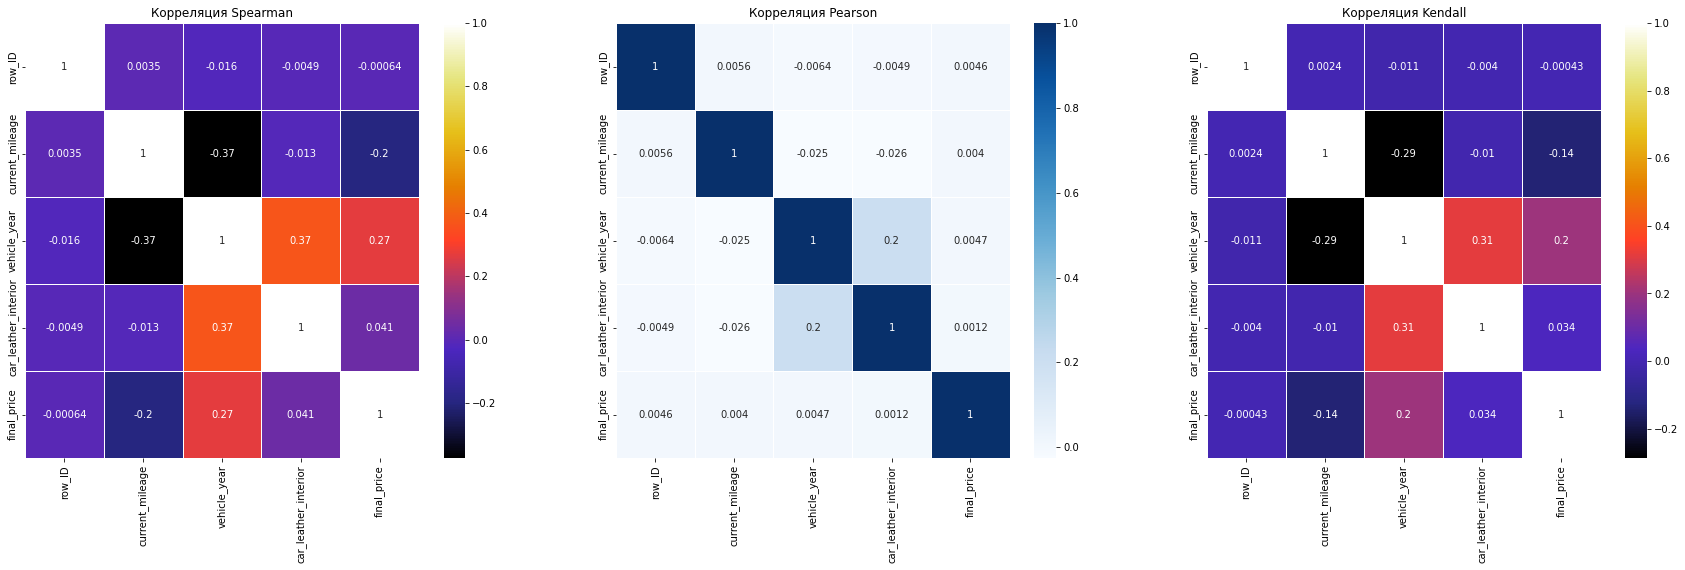

In [94]:
def correlation(df):
    """функция визуализирует тепловые карты корреляции по методам : Спирмена, Пирсена и Кендалла

    Args:
        df (DataFrame): таблица csv содержащая данные для предсказания цены на автомобили
    """
       
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 3, 1)
    sns.heatmap(df.corr(method='spearman'), annot=True, linewidths=.5, cmap='CMRmap')
    plt.title ('Корреляция Spearman')

    plt.subplot(1, 3, 2)
    sns.heatmap(df.corr(method=('pearson')), annot=True, linewidths=.5, cmap='Blues')
    plt.title ('Корреляция Pearson')

    plt.subplot(1, 3, 3)
    sns.heatmap(df.corr(method=('kendall')), annot=True, linewidths=.5, cmap='CMRmap')
    plt.title ('Корреляция Kendall')
    
cor = correlation(df)

Из представленных тепловых карт видно, что корреляция признаков слабая. Из трех графов, первый -  корреляция Спирмена наиболее информативна. Почти все признаки слабо коррелируют между собой за исключением пары - car_leather_interior и current_mileage

In [ ]:
# добавляем новый признак - old_year возраст машины

#df['vehicle_year'] = df['vehicle_year'] + (-2000) 
#df.head()
#df.drop('vehicle_year', axis=1, inplace=True)
#cor = correlation(df)

In [ ]:
# поиск дубликатов
def find_dupl(df):
    """Функция возвращает количество добликатов строк

    Args:
        df (DataFrame): таблица csv содержащая данные для предсказания цены на автомобили
    """
    #создаем список наименование колонок и удаляем индекс
    df_cols = list(df.columns)
    #diabetes_cols.remove('id')

    # создаем маску дубликатов и выводим количество повторяющихся строк
    mask=df.duplicated(subset=df_cols)
    df_dupl=df[mask]
    display(f'Число повторяющихся строк: {df_dupl.shape[0]}')
    return dupl
    
dupl = find_dupl(df)    

Функция показывает, что в датасете имеется большое кол-во дубликатов строк. Такое возможно т.к. были удалены уникальные значения признаков vin и row_ID

In [ ]:
df.info()

In [ ]:


# смотрим год выпуска автомобиля
df['vehicle_year'].unique() # присутствует нулевое значение
df = df[df.vehicle_year > 0] # удаляем строку с нулевым значением



Проверяем признаки на неинформативность

In [ ]:
# выявим неинформатиные признаки

def low_informative_feature(data):
    low_information_cols = []
    for col in data.columns:
        top_freq = data[col].value_counts(normalize=True).max()
        nunique_ratio = data[col].nunique() / data[col].count()
        if top_freq > 0.95:
            low_information_cols.append(col)
        if nunique_ratio > 0.95:
            low_information_cols.append(col)
    return low_information_cols
low_information_cols = low_informative_feature(df)
display(low_information_cols)

In [ ]:
# просматриваем неинформативный признак на варинаты значений - их всего два
df['deal_type'].value_counts()

In [ ]:
# проверяем на нулевые значения
df['deal_type'].isnull().sum()

In [ ]:
# После проверки допускаем, что признак неинформативен и удаляем его.
df.drop('deal_type', axis=1, inplace=True)

In [ ]:
df.info()

In [ ]:
'''
df_copy = df.copy()
#df_copy['test'] = df_copy['doors_cnt'].apply(lambda x: x.astype(str).str[-1])
df_copy['doors_cnt'] = df_copy['doors_cnt'] = df.doors_cnt.str[-1:]
#df_copy.head()
#df_copy['doors_cnt'].value_counts(normalize=True) *100
#df_copy = df_copy['doors_cnt'].isnull()
#df_copy['doors_cnt'] = df_copy['doors_cnt'] = df['doors_cnt'].fillna('unknown')
df_copy.head()
'''

In [ ]:
'''
def nan_function(x):
    return np.nan if x == 0 else x
diabetes_clear["Glucose"] = diabetes_clear["Glucose"].apply(nan_function)
diabetes_clear["BloodPressure"] = diabetes_clear["BloodPressure"].apply(nan_function)
diabetes_clear["SkinThickness"] = diabetes_clear["SkinThickness"].apply(nan_function)
'''

Просмотрим признаки с пропущенными значениями

In [ ]:
df['doors_cnt'].value_counts(normalize=True) *100

In [ ]:
df['doors_cnt'].isnull().sum()

In [ ]:
mode_color = df_copy['vehicle_color'].mode() # mode = Black
df_copy['vehicle_color'] = df_copy['vehicle_color'].fillna(mode_color)


In [ ]:
df_copy.info()

In [ ]:
x = df_copy.isnull().sum()
x